In [2]:
import pandas as pd 
import numpy as np 
from scipy.stats import norm, kurtosis, skew, kstest
import os



In [3]:
import sys
from pathlib import Path

# Point to the project root (parent of "models" and "utils")
project_root = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print("Project root:", project_root)

Project root: /Users/jan/Documents/working papers/project 1


In [4]:
PATH = r'/Users/jan/Documents/working papers/project 1/data/btcusd_1-min_data.csv'

df = pd.read_csv(PATH)

In [5]:
df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']

In [6]:
#UNIX to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

In [7]:
df.set_index('timestamp', inplace=True)
df.sort_index(inplace=True)

In [8]:
df = df[~df.index.duplicated()]
df = df[(df[['open', 'high', 'low', 'close']] != 0).any(axis=1)]

In [9]:
print(df.isna().sum())

open      0
high      0
low       0
close     0
volume    0
dtype: int64


In [10]:
print(df.head())

                     open  high   low  close  volume
timestamp                                           
2012-01-01 10:01:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:02:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:03:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:04:00  4.58  4.58  4.58   4.58     0.0
2012-01-01 10:05:00  4.58  4.58  4.58   4.58     0.0


In [11]:
print(df.tail(10))

                         open      high       low     close    volume
timestamp                                                            
2025-07-22 00:42:00  117217.0  117217.0  117101.0  117101.0  0.117653
2025-07-22 00:43:00  117101.0  117149.0  117101.0  117149.0  0.060733
2025-07-22 00:44:00  117161.0  117161.0  117057.0  117115.0  0.696926
2025-07-22 00:45:00  117115.0  117184.0  117115.0  117184.0  0.670449
2025-07-22 00:46:00  117228.0  117320.0  117197.0  117320.0  0.551232
2025-07-22 00:47:00  117351.0  117367.0  117304.0  117304.0  0.034629
2025-07-22 00:48:00  117315.0  117315.0  117257.0  117269.0  0.019866
2025-07-22 00:49:00  117269.0  117314.0  117269.0  117310.0  0.159321
2025-07-22 00:50:00  117330.0  117349.0  117250.0  117250.0  2.547802
2025-07-22 00:51:00  117214.0  117292.0  117207.0  117240.0  0.174960


In [12]:
print(df.columns)

Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')


In [13]:

intervals = {
    '5m': '5T',
    '15m': '15T',
    '1h': '60T'
}

agg_rules = {
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}

resampled_dfs = {
    name: df.resample(freq).agg(agg_rules).dropna()
    for name, freq in intervals.items()
}


df_5m = resampled_dfs['5m']
df_15m = resampled_dfs['15m']
df_1h = resampled_dfs['1h']



/var/folders/pq/224wz8116dq05pr87bp6rkb80000gn/T/ipykernel_99291/2435590344.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  name: df.resample(freq).agg(agg_rules).dropna()
/var/folders/pq/224wz8116dq05pr87bp6rkb80000gn/T/ipykernel_99291/2435590344.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  name: df.resample(freq).agg(agg_rules).dropna()
/var/folders/pq/224wz8116dq05pr87bp6rkb80000gn/T/ipykernel_99291/2435590344.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  name: df.resample(freq).agg(agg_rules).dropna()


In [14]:
save_dir = os.path.join(os.getcwd(), "/Users/jan/Documents/working papers/project 1/data")
os.makedirs(save_dir, exist_ok=True)  

df_5m.to_csv(os.path.join(save_dir, "btc_5m.csv"))
df_15m.to_csv(os.path.join(save_dir, "btc_15m.csv"))
df_1h.to_csv(os.path.join(save_dir, "btc_1h.csv"))

print(f"saved in: {os.path.abspath(save_dir)}")


saved in: /Users/jan/Documents/working papers/project 1/data


descriptive statistics table

In [15]:
def simple_returns(df, interval):
    ohlc = df['close'].resample(f'{interval}min').ohlc()
    returns = (ohlc['close'] - ohlc['open']) / ohlc['open']
    return returns.dropna()

def get_stats(series):
    stats = {}
    stats['count'] = series.count()
    stats['mean'] = series.mean()
    stats['std'] = series.std()
    stats['min'] = series.min()
    stats['25% percentile'] = series.quantile(0.25)
    stats['50% percentile'] = series.quantile(0.50)
    stats['75% percentile'] = series.quantile(0.75)
    stats['max'] = series.max()
    stats['kurtosis'] = kurtosis(series, fisher=False)
    stats['skewness'] = skew(series)
    ks_stat, ks_p = kstest(series, 'norm', args=(series.mean(), series.std()))
    stats['KS test stat.'] = ks_stat
    stats['KS test p-value'] = ks_p
    return stats

intervals = [5, 15, 30]
result = {}

for interval in intervals:
    returns = simple_returns(df, interval)
    result[f'{interval}min'] = get_stats(returns)

stats_df = pd.DataFrame(result)
stats_df.index.name = 'Statistic'

stats_df = pd.DataFrame(result)
stats_df.index.name = 'Statistic'


In [16]:
def custom_format(row):
    if row.name == 'count':
        return row.apply(lambda x: f"{int(round(x))}")
    elif row.name == 'KS test p-value':
        return row.apply(lambda x: f"{x:.2e}")
    else:
        return row.apply(lambda x: f"{x:.8f}")

formatted_df = stats_df.apply(custom_format, axis=1)


In [17]:
import IPython.display as ipd
ipd.display(formatted_df)

,5min,15min,30min
Statistic,,,
count,1425548,475184,237593
mean,0.00000567,0.00001408,0.00005514
std,0.00315260,0.00544743,0.00750949
min,-0.24375000,-0.24179310,-0.35716672
25% percentile,-0.00063171,-0.00126039,-0.00177944
50% percentile,0.00000000,0.00000000,0.00000000
75% percentile,0.00066484,0.00133097,0.00192816
max,0.74990000,0.98852273,0.98852273
kurtosis,3499.38529553,2546.26693028,1450.37601878


problem with extreme max (solved)

In [18]:

returns_15min = simple_returns(df, 15)
returns_30min = simple_returns(df, 30)

threshold = 0.2

outliers_15min = returns_15min[np.abs(returns_15min) > threshold]
outliers_30min = returns_30min[np.abs(returns_30min) > threshold]

print("Extreme 15min intervals:")
display(df.loc[outliers_15min.index])

print("Extreme 30min intervals:")
display(df.loc[outliers_30min.index])

Extreme 15min intervals:


,open,high,low,close,volume
timestamp,,,,,
2012-01-19 11:00:00,7.10,7.10,7.10,7.10,0.000000
2012-01-19 14:45:00,5.52,5.52,5.52,5.52,0.000000
2012-02-14 18:00:00,4.70,4.70,4.70,4.70,0.000000
2012-08-18 00:30:00,11.99,11.99,11.99,11.99,0.100000
2013-04-10 22:30:00,96.20,96.20,88.00,88.00,82.042582
2013-04-11 19:00:00,100.00,100.00,99.00,99.00,68.425751
2013-04-11 20:30:00,79.00,79.00,79.00,79.00,0.000000
2013-04-11 22:30:00,72.50,73.99,72.50,72.50,17.473523
2013-04-11 22:45:00,54.00,54.00,50.00,51.00,238.743220


Extreme 30min intervals:


,open,high,low,close,volume
timestamp,,,,,
2012-01-19 11:00:00,7.10,7.10,7.10,7.10,0.000000
2012-01-19 14:30:00,5.52,5.52,5.52,5.52,0.000000
2012-02-14 18:00:00,4.70,4.70,4.70,4.70,0.000000
2012-08-18 00:30:00,11.99,11.99,11.99,11.99,0.100000
2013-04-10 21:30:00,191.60,191.60,191.00,191.00,1.058987
2013-04-10 22:00:00,149.65,149.65,149.65,149.65,0.308804
2013-04-10 22:30:00,96.20,96.20,88.00,88.00,82.042582
2013-04-10 23:00:00,184.00,184.00,160.00,160.00,96.397353
2013-04-11 19:00:00,100.00,100.00,99.00,99.00,68.425751


In [19]:
returns_15min = simple_returns(df, 15)
returns_30min = simple_returns(df, 30)

max_15min = returns_15min.idxmax()
max_30min = returns_30min.idxmax()

print("Max 15min return row:")
display(df.loc[max_15min - pd.Timedelta('15min'):max_15min + pd.Timedelta('15min')])

print("Max 30min return row:")
display(df.loc[max_30min - pd.Timedelta('30min'):max_30min + pd.Timedelta('30min')])

print("15min bar: open/close/max return:", df['close'].resample('15min').ohlc().loc[max_15min][['open','close']], returns_15min.loc[max_15min])
print("30min bar: open/close/max return:", df['close'].resample('30min').ohlc().loc[max_30min][['open','close']], returns_30min.loc[max_30min])

Max 15min return row:


,open,high,low,close,volume
timestamp,,,,,
2013-04-10 22:15:00,128.00,128.00,120.15,120.15,52.275207
2013-04-10 22:16:00,120.15,120.15,120.00,120.00,24.031563
2013-04-10 22:17:00,120.00,120.15,120.00,120.15,50.905488
2013-04-10 22:18:00,120.15,120.15,110.00,110.00,2.450957
2013-04-10 22:19:00,121.00,121.00,110.00,120.15,10.197291
2013-04-10 22:20:00,120.15,121.00,110.00,110.00,131.254283
2013-04-10 22:21:00,110.00,110.00,110.00,110.00,32.593735
2013-04-10 22:22:00,110.00,110.00,110.00,110.00,157.448997
2013-04-10 22:23:00,110.00,110.00,109.00,109.00,112.187959


Max 30min return row:


,open,high,low,close,volume
timestamp,,,,,
2013-04-10 22:00:00,149.65,149.65,149.65,149.65,0.308804
2013-04-10 22:01:00,149.60,149.60,149.60,149.60,1.129078
2013-04-10 22:02:00,147.02,147.02,147.02,147.02,0.588903
2013-04-10 22:03:00,146.00,146.00,146.00,146.00,2.360411
2013-04-10 22:04:00,146.00,146.00,146.00,146.00,0.545685
...,...,...,...,...,...
2013-04-10 22:56:00,189.90,189.90,185.00,185.00,1.805917
2013-04-10 22:57:00,180.00,185.00,180.00,180.00,51.482556
2013-04-10 22:58:00,180.00,181.00,175.00,175.00,7.781722


15min bar: open/close/max return: open      88.00
close    174.99
Name: 2013-04-10 22:30:00, dtype: float64 0.9885227272727274
30min bar: open/close/max return: open      88.00
close    174.99
Name: 2013-04-10 22:30:00, dtype: float64 0.9885227272727274


consecutive repeatable price values

In [20]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = df.sort_index()
df.index = pd.to_datetime(df.index)

def find_equal_close_runs(subdf: pd.DataFrame):
    same_price_series = []
    start_time = None
    length = 1
    idx = subdf.index
    close = subdf['close'].to_numpy()

    for i in range(1, len(subdf)):
        time_diff = (idx[i] - idx[i - 1]).total_seconds()
        if time_diff == 60 and close[i] == close[i - 1]:
            if start_time is None:
                start_time = idx[i - 1]
            length += 1
        else:
            if start_time is not None and length > 1:
                same_price_series.append((start_time, length))
            start_time = None
            length = 1

    if start_time is not None and length > 1:
        same_price_series.append((start_time, length))

    lengths = [L for _, L in same_price_series]
    return lengths, pd.DataFrame(same_price_series, columns=["start_timestamp", "length"])



In [21]:
# year
runs_year_rows = []
year_tables = {}  
for year, g in df.groupby(df.index.year):
    lens, tbl = find_equal_close_runs(g)
    if lens:
        runs_year_rows += [{"year": int(year), "length": int(L)} for L in lens]
        year_tables[int(year)] = tbl

runs_by_year = pd.DataFrame(runs_year_rows)


In [22]:
# month
runs_month_rows = []
month_tables = {}
for (year, month), g in df.groupby([df.index.year, df.index.month]):
    lens, tbl = find_equal_close_runs(g)
    if lens:
        runs_month_rows += [{"year": int(year), "month": int(month), "length": int(L)} for L in lens]
        month_tables[(int(year), int(month))] = tbl

runs_by_month = pd.DataFrame(runs_month_rows)


In [23]:
print("Per-year run counts (first 10):")
if not runs_by_year.empty:
    print(runs_by_year.groupby("year")["length"].count().head(10))
else:
    print("No runs found per-year.")



Per-year run counts (first 10):
year
2012     12345
2013     83739
2014    100742
2015     97701
2016    106120
2017     58059
2018     33884
2019     32906
2020     16311
2021      4878
Name: length, dtype: int64


In [24]:
print("\nPer-(year, month) run counts (first 15):")
if not runs_by_month.empty:
    print(runs_by_month.groupby(["year", "month"])["length"].count().head(15))
else:
    print("No runs found per-month.")


Per-(year, month) run counts (first 15):
year  month
2012  1         171
      2         312
      3         358
      4         461
      5         412
      6         921
      7        1160
      8        2017
      9        1409
      10       1775
      11       1752
      12       1608
2013  1        2108
      2        2872
      3        5707
Name: length, dtype: int64


/var/folders/pq/224wz8116dq05pr87bp6rkb80000gn/T/ipykernel_99291/3737587456.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_years, labels=[str(y) for y in years], showfliers=False)


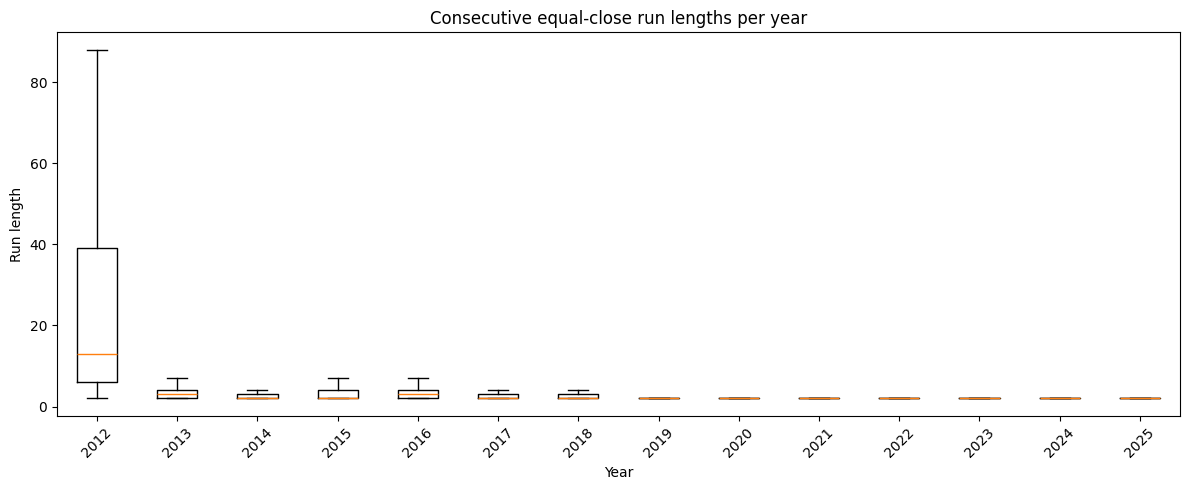

In [25]:
if not runs_by_year.empty:
    years = sorted(runs_by_year["year"].unique())
    data_years = [runs_by_year.loc[runs_by_year["year"] == y, "length"].to_numpy() for y in years]
    plt.figure(figsize=(12, 5))
    plt.boxplot(data_years, labels=[str(y) for y in years], showfliers=False)
    plt.title("Consecutive equal-close run lengths per year")
    plt.xlabel("Year")
    plt.ylabel("Run length")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/var/folders/pq/224wz8116dq05pr87bp6rkb80000gn/T/ipykernel_99291/4262036191.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_plot, labels=labels, showfliers=False)


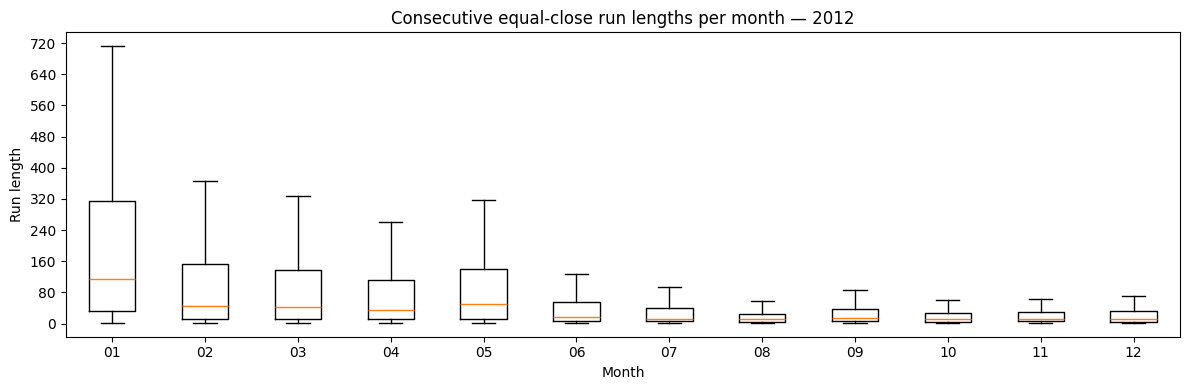

/var/folders/pq/224wz8116dq05pr87bp6rkb80000gn/T/ipykernel_99291/4262036191.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_plot, labels=labels, showfliers=False)


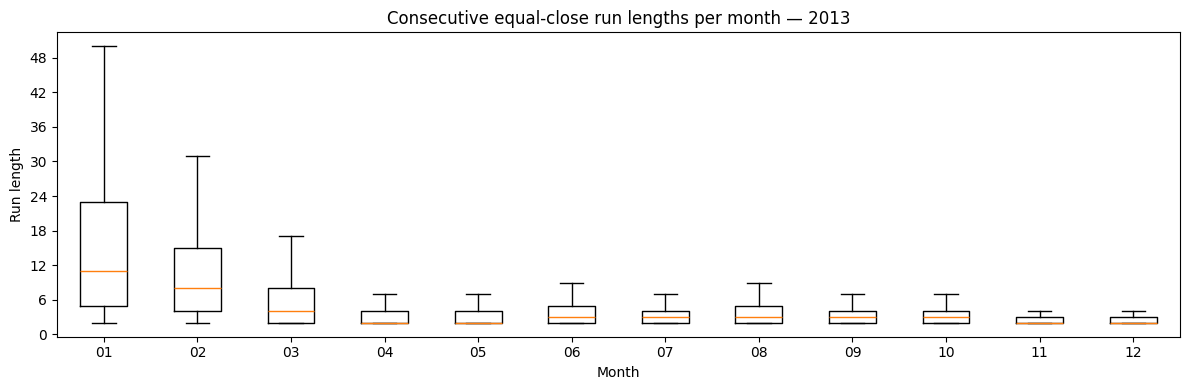

/var/folders/pq/224wz8116dq05pr87bp6rkb80000gn/T/ipykernel_99291/4262036191.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_plot, labels=labels, showfliers=False)


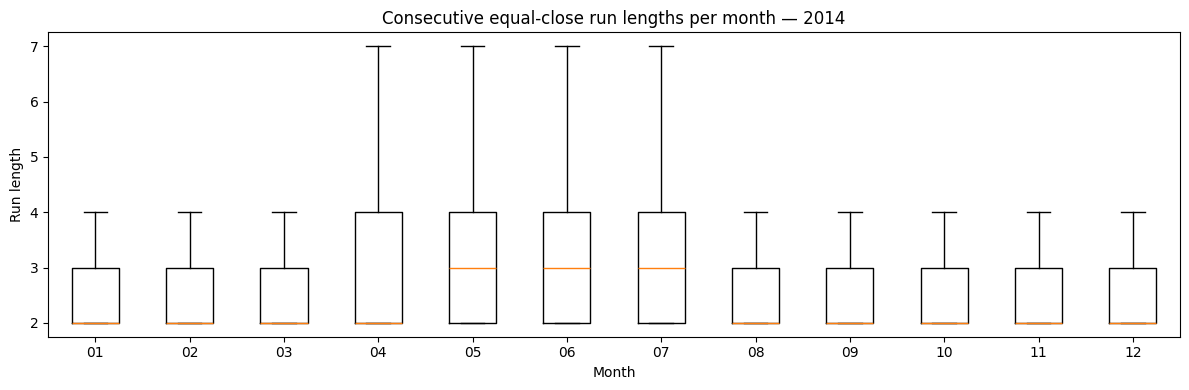

/var/folders/pq/224wz8116dq05pr87bp6rkb80000gn/T/ipykernel_99291/4262036191.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_plot, labels=labels, showfliers=False)


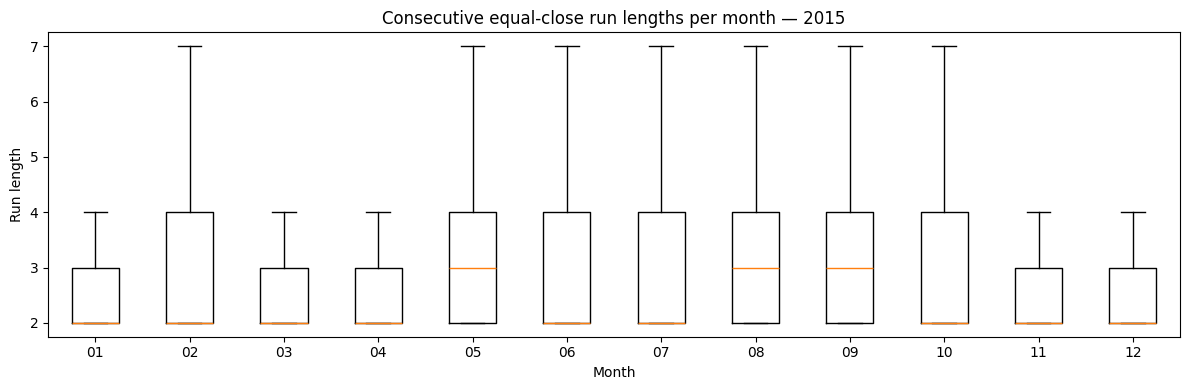

/var/folders/pq/224wz8116dq05pr87bp6rkb80000gn/T/ipykernel_99291/4262036191.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_plot, labels=labels, showfliers=False)


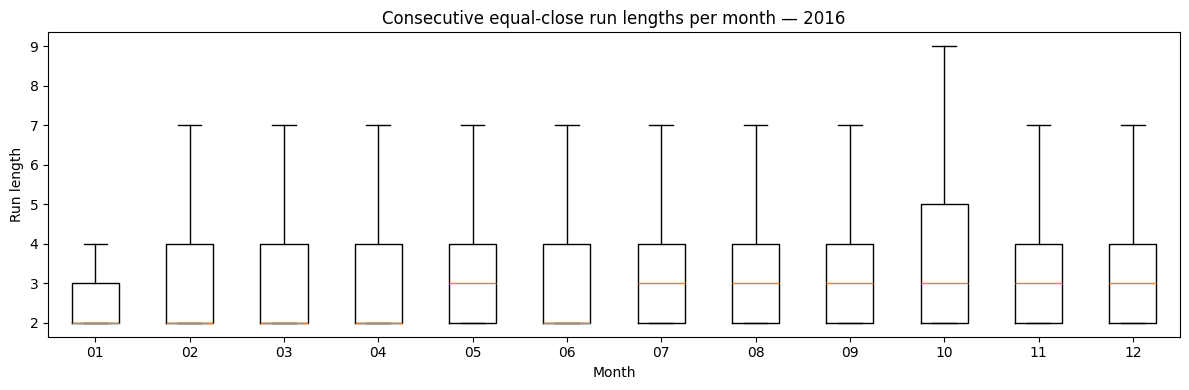

/var/folders/pq/224wz8116dq05pr87bp6rkb80000gn/T/ipykernel_99291/4262036191.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_plot, labels=labels, showfliers=False)


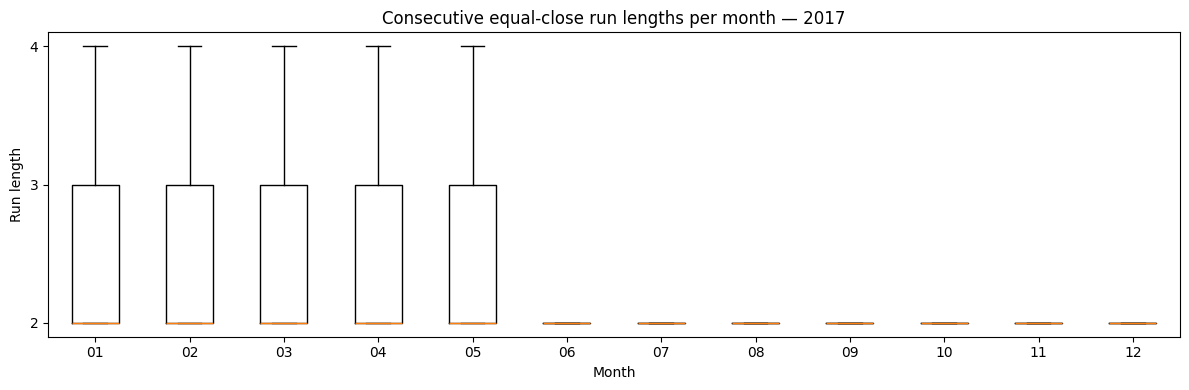

/var/folders/pq/224wz8116dq05pr87bp6rkb80000gn/T/ipykernel_99291/4262036191.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_plot, labels=labels, showfliers=False)


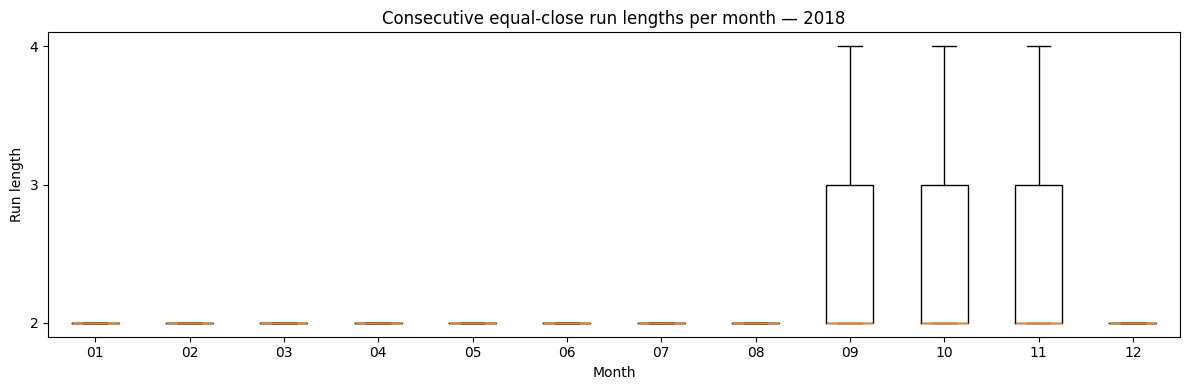

/var/folders/pq/224wz8116dq05pr87bp6rkb80000gn/T/ipykernel_99291/4262036191.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_plot, labels=labels, showfliers=False)


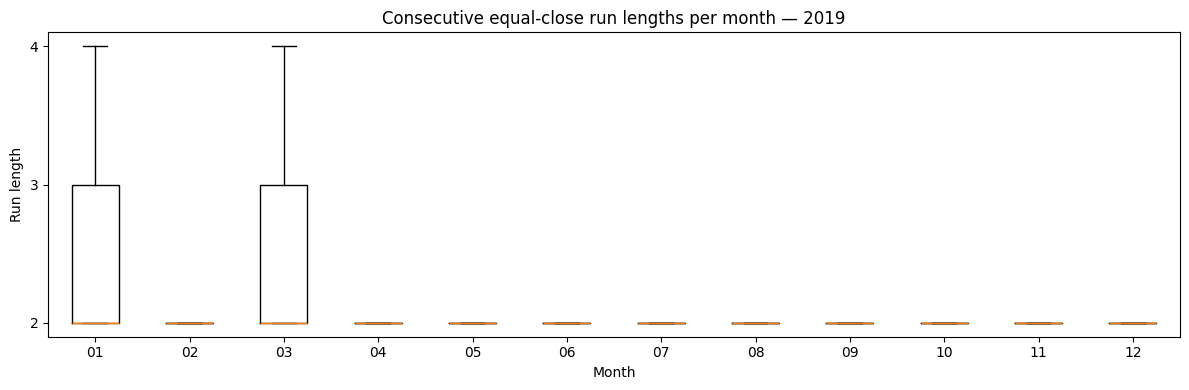

/var/folders/pq/224wz8116dq05pr87bp6rkb80000gn/T/ipykernel_99291/4262036191.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_plot, labels=labels, showfliers=False)


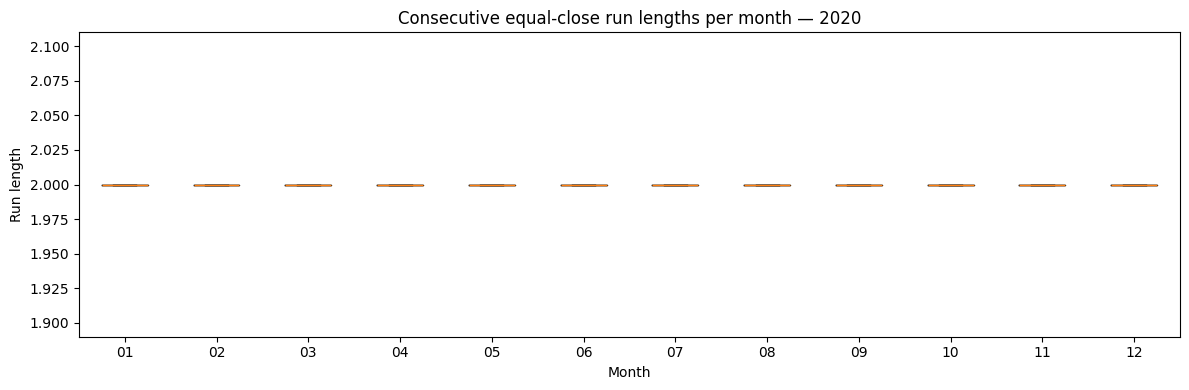

/var/folders/pq/224wz8116dq05pr87bp6rkb80000gn/T/ipykernel_99291/4262036191.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_plot, labels=labels, showfliers=False)


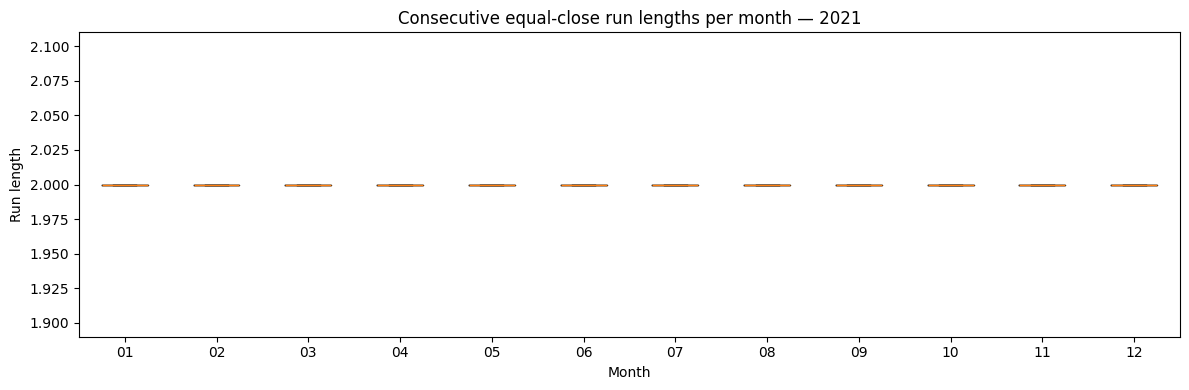

/var/folders/pq/224wz8116dq05pr87bp6rkb80000gn/T/ipykernel_99291/4262036191.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_plot, labels=labels, showfliers=False)


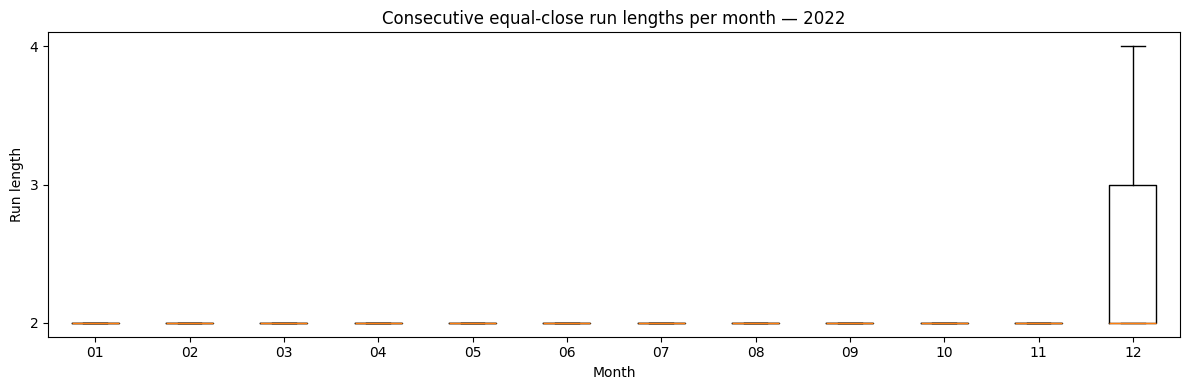

/var/folders/pq/224wz8116dq05pr87bp6rkb80000gn/T/ipykernel_99291/4262036191.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_plot, labels=labels, showfliers=False)


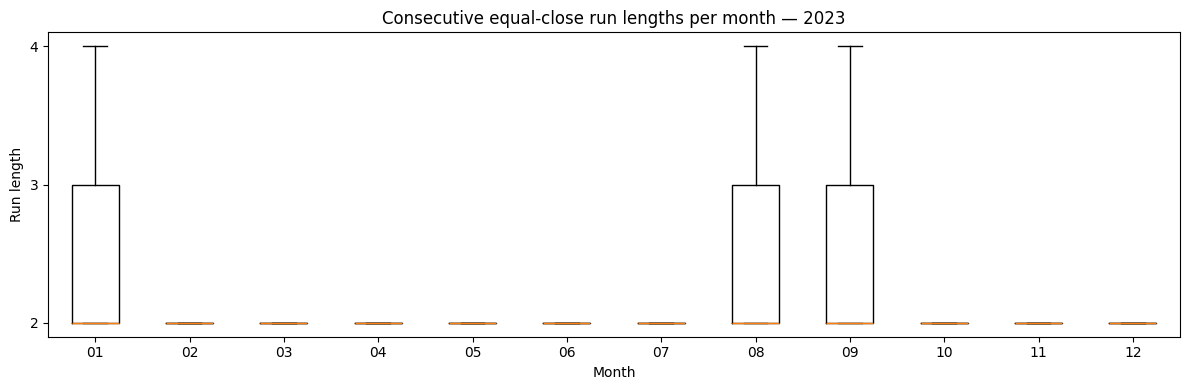

/var/folders/pq/224wz8116dq05pr87bp6rkb80000gn/T/ipykernel_99291/4262036191.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_plot, labels=labels, showfliers=False)


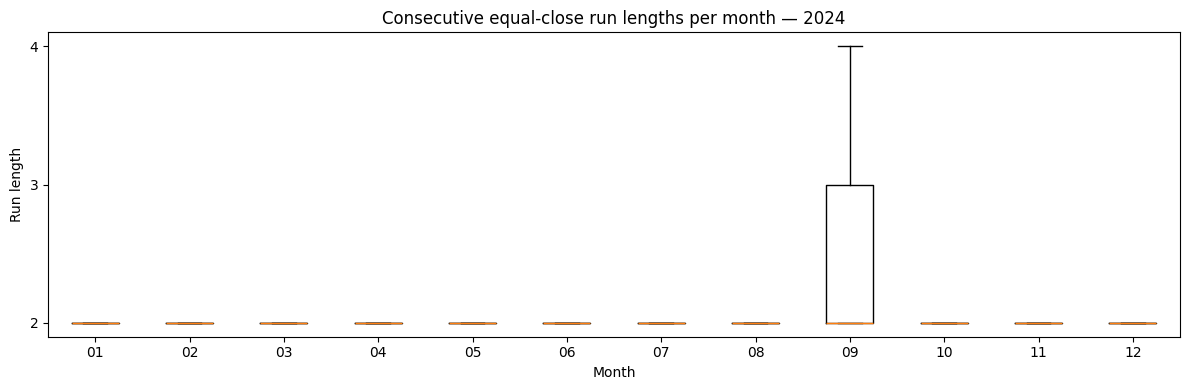

/var/folders/pq/224wz8116dq05pr87bp6rkb80000gn/T/ipykernel_99291/4262036191.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_plot, labels=labels, showfliers=False)


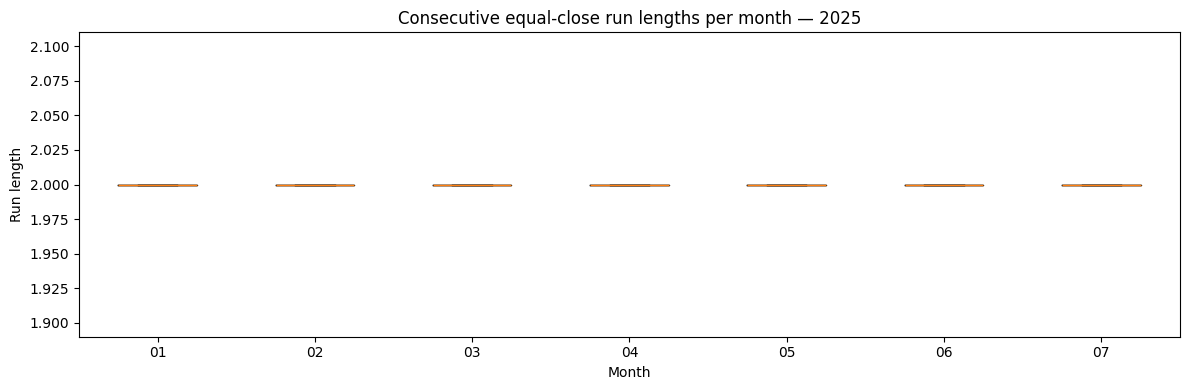

In [26]:
from matplotlib.ticker import MaxNLocator

if not runs_by_month.empty:
    for y in sorted(runs_by_month["year"].unique()):
        data_plot, labels = [], []
        for m in range(1, 13):
            arr = runs_by_month.loc[
                (runs_by_month["year"] == y) & (runs_by_month["month"] == m),
                "length"
            ].to_numpy()
            if arr.size > 0:
                data_plot.append(arr)
                labels.append(f"{m:02d}")

        if not data_plot:
            continue  

        plt.figure(figsize=(12, 4))
        plt.boxplot(data_plot, labels=labels, showfliers=False)
        plt.title(f"Consecutive equal-close run lengths per month — {y}")
        plt.xlabel("Month")
        plt.ylabel("Run length")

        ax = plt.gca()
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

        plt.tight_layout()
        plt.show()
else:
    print("runs_by_month is empty; nothing to plot.")

In [27]:
_, same_price_df = find_equal_close_runs(df)
print("\nOriginal-style table over full range:")
print(same_price_df.head(10))


Original-style table over full range:
      start_timestamp  length
0 2012-01-01 10:01:00     627
1 2012-01-01 20:28:00     437
2 2012-01-02 03:45:00    2220
3 2012-01-03 16:45:00     157
4 2012-01-03 19:22:00      32
5 2012-01-03 19:54:00      38
6 2012-01-03 20:32:00     102
7 2012-01-03 22:14:00      12
8 2012-01-03 22:26:00     651
9 2012-01-04 09:17:00     504


Counts-by-length per (year, month) since 2013 (head):
length       1     2     3     4     5     6     7     8     9     10    ...  \
year month                                                               ...   
2013 1        609   233   168   120   126    92    82    84    53    75  ...   
     2       1008   422   289   218   204   160   113   130   106   114  ...   
     3       3173  1487   932   622   478   347   264   215   174   156  ...   
     4      13838  4226  1663   903   517   320   188   140   100    54  ...   
     5      15305  4332  1716   891   502   323   199   126    91    85  ...   
...           ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2025 3      38484  1795   250    75    23     8     4     7     0     0  ...   
     4      38849  1714   214    48    10     3     3     0     0     0  ...   
     5      40417  1690   186    51     9     6     0     0     0     0  ...   
     6      37644  1958   304    94    31    10     4     7     2 

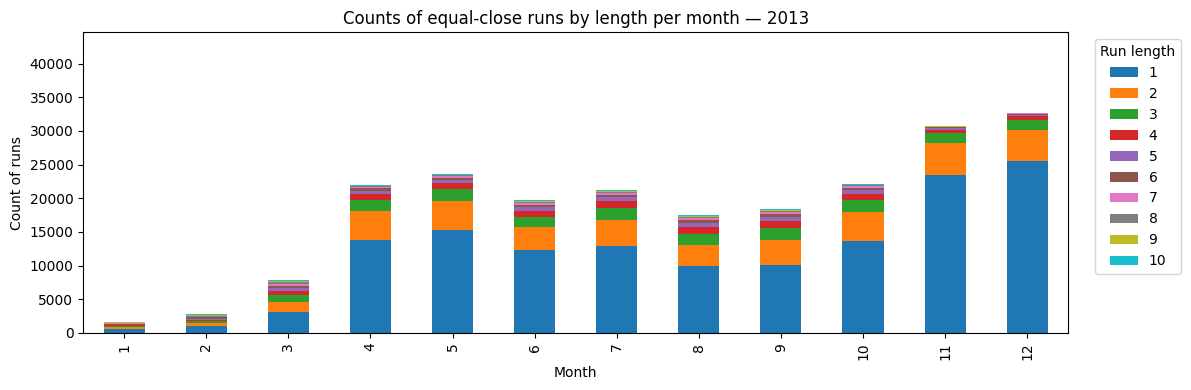

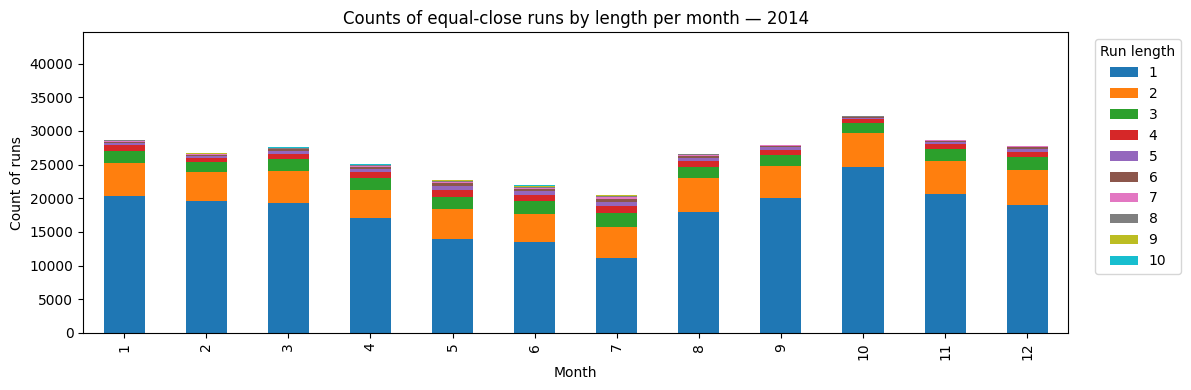

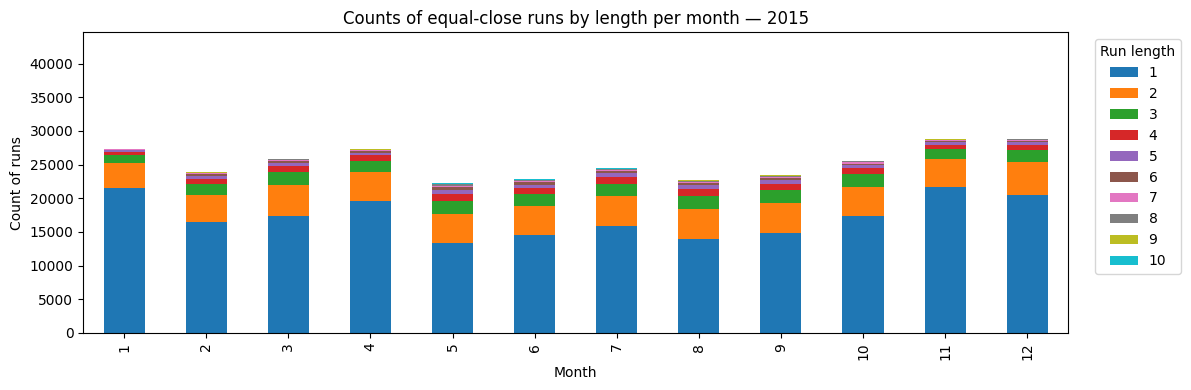

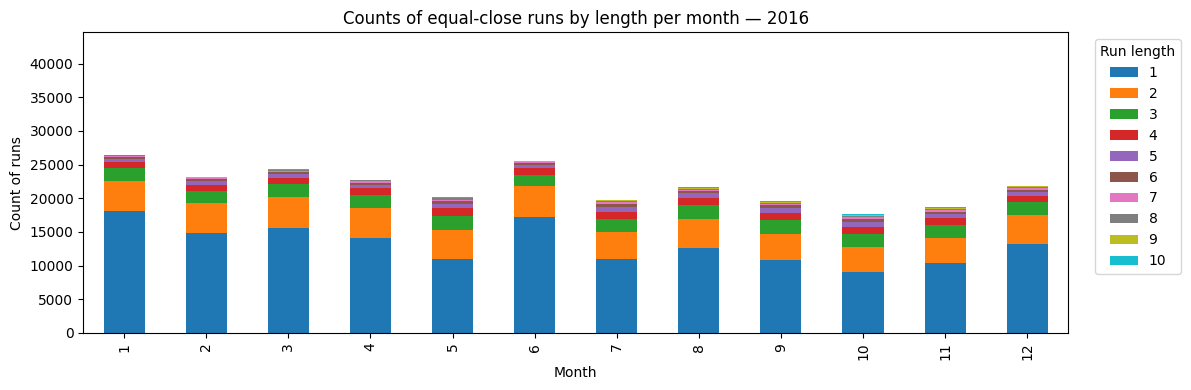

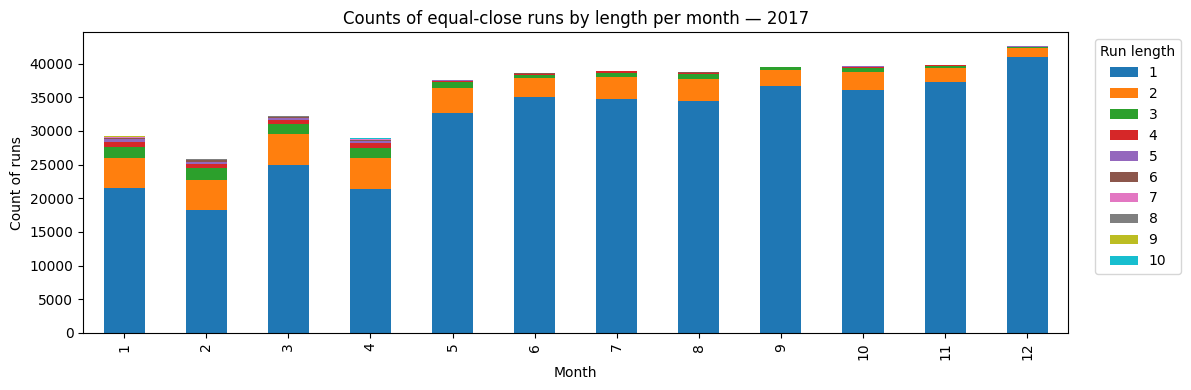

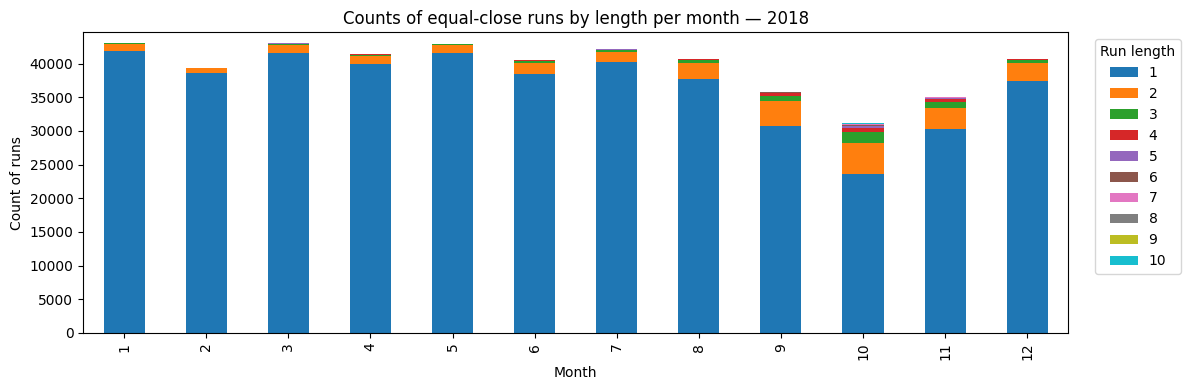

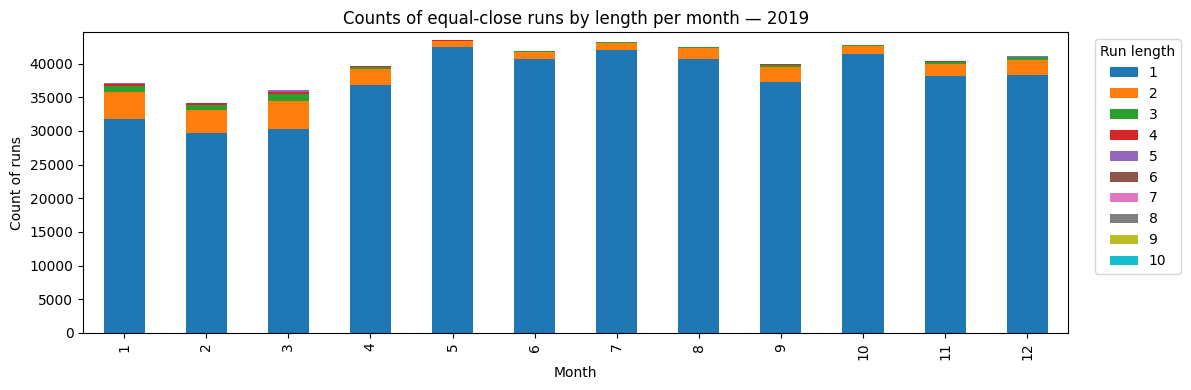

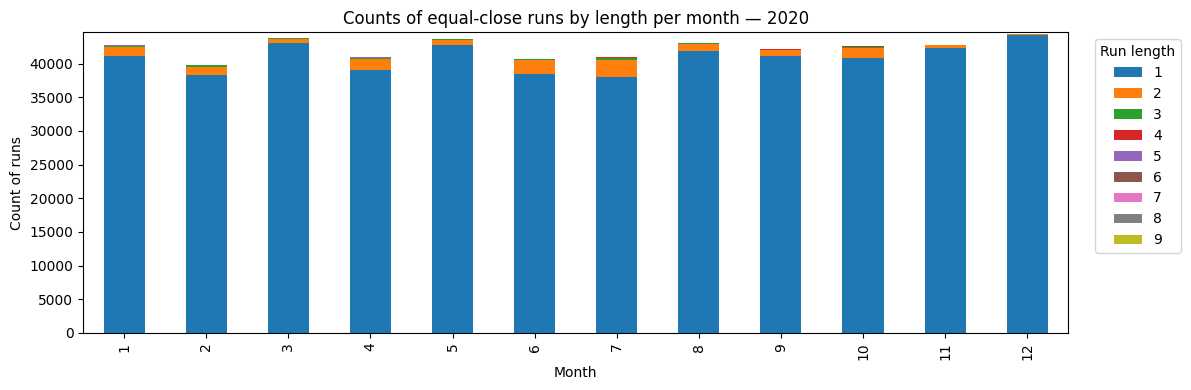

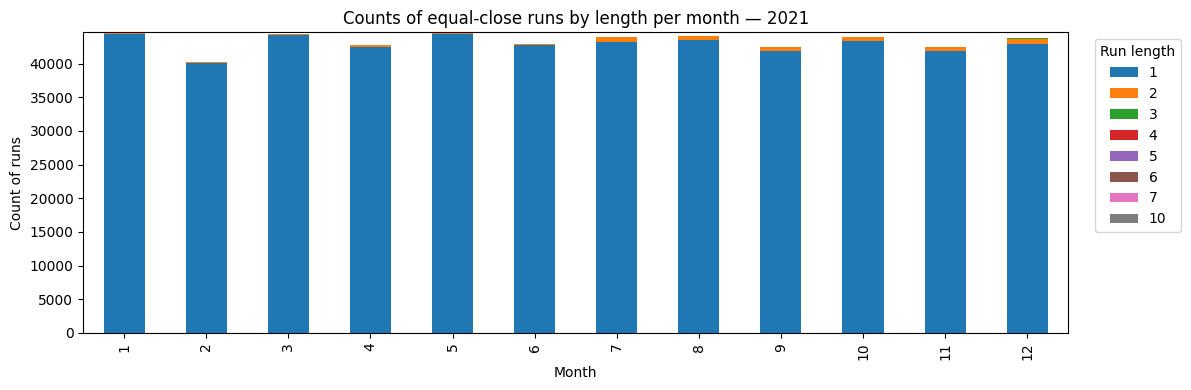

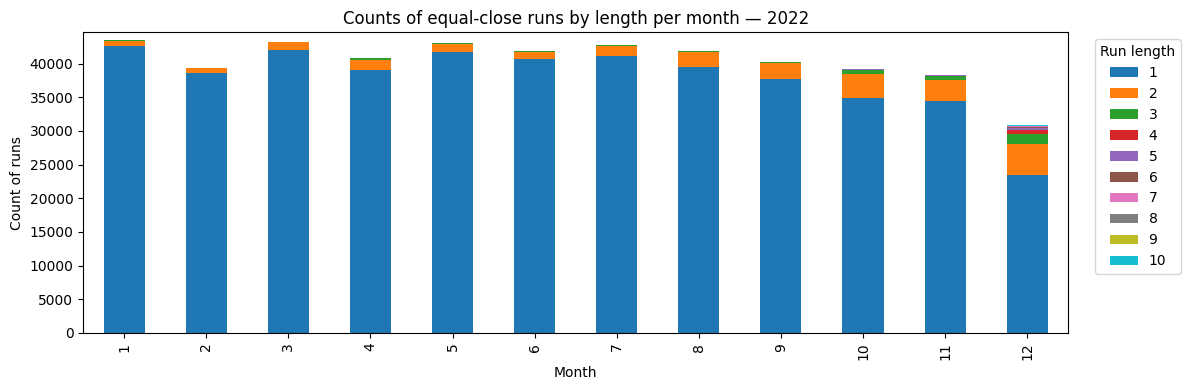

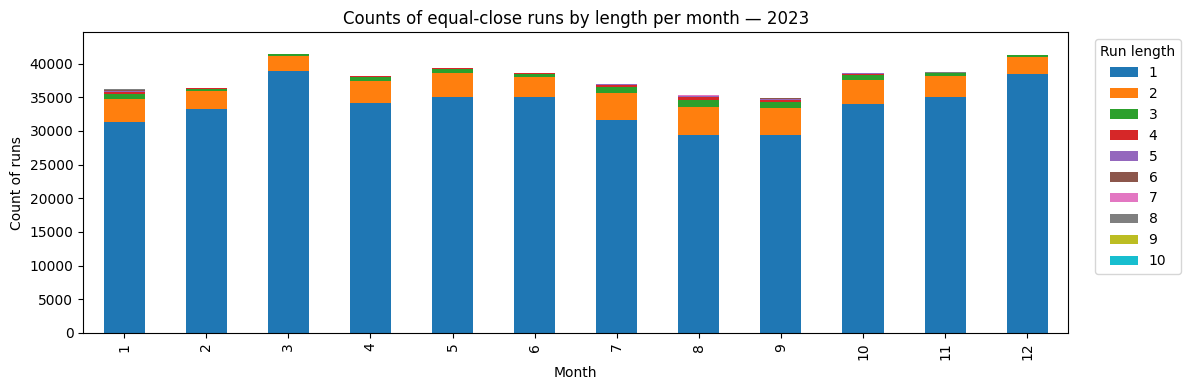

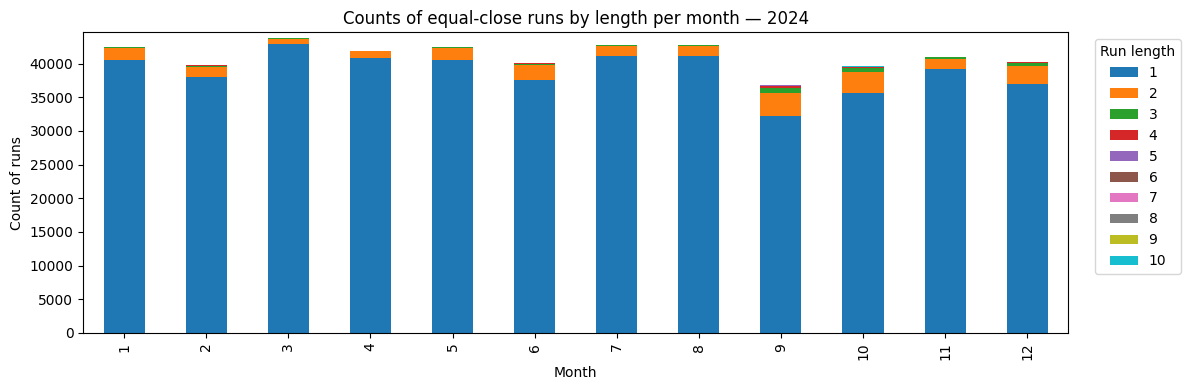

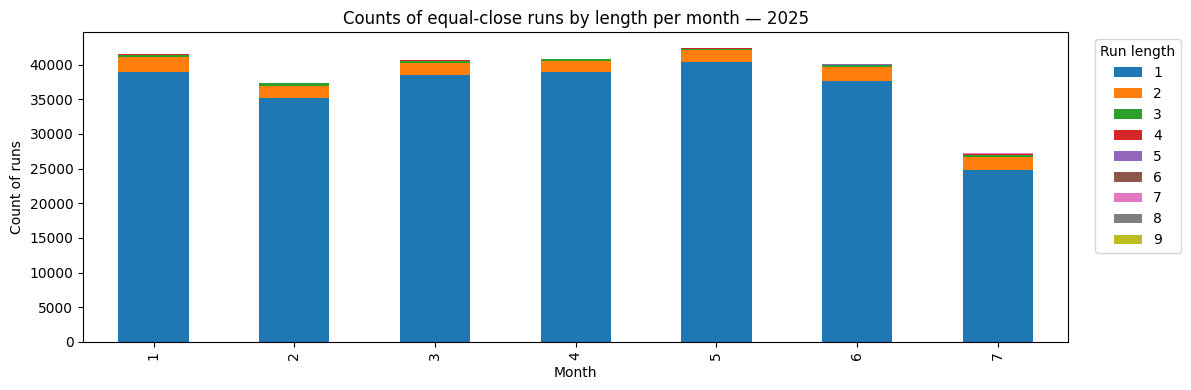

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

df = df.sort_index()
df.index = pd.to_datetime(df.index)

def find_equal_close_runs_including_1(subdf: pd.DataFrame):
    """Run-lengths of identical close values on consecutive minutes.
    Yields lengths >= 1 (i.e., includes singletons)."""
    n = len(subdf)
    if n == 0:
        return []
    idx = subdf.index
    close = subdf["close"].to_numpy()

    runs = []
    length = 1
    for i in range(1, n):
        cont = (idx[i] - idx[i-1]).total_seconds() == 60
        same = cont and (close[i] == close[i-1])
        if same:
            length += 1
        else:
            runs.append(length)
            length = 1
    runs.append(length)
    return runs


rows = []
for (y, m), g in df.groupby([df.index.year, df.index.month]):
    L = find_equal_close_runs_including_1(g)
    if L:
        rows += [{"year": int(y), "month": int(m), "length": int(l)} for l in L]

runs_by_month = pd.DataFrame(rows)



rbm14 = runs_by_month.loc[runs_by_month["year"] >= 2013].copy()

counts_long = (
    rbm14.groupby(["year", "month", "length"])
         .size()
         .rename("count")
         .reset_index()
)

counts_wide = (
    counts_long.pivot_table(index=["year", "month"],
                            columns="length",
                            values="count",
                            fill_value=0)
               .sort_index()
               .astype(int)
)

print("Counts-by-length per (year, month) since 2013 (head):")
print(counts_wide)

counts_wide.to_csv("lenghts_count_btc_since2013.csv")

#plots
for y, g in counts_long.groupby("year"):
    pivot = (
        g.groupby(["month", "length"])["count"]
         .sum()
         .unstack(fill_value=0)
         .sort_index()
    )
    # lengths 1 to 10 in stack only
    keep_cols = [c for c in pivot.columns if isinstance(c, (int, np.integer)) and 1 <= c <= 10]
    if not keep_cols:
        continue
    pivot_plot = pivot[keep_cols]

    ax = pivot_plot.plot(kind="bar", stacked=True, figsize=(12, 4))
    ax.set_title(f"Counts of equal-close runs by length per month — {y}")
    ax.set_xlabel("Month")
    ax.set_ylabel("Count of runs")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim(0, 44640)
    ax.legend(title="Run length", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

In [41]:
# ASD from minutely returns, by calendar month
import numpy as np
import pandas as pd

RULE = '1T'                  # minutely bars
H = 365 * 24 * 60            # periods per year (for btc its 24/7)


Pt = (
    df['close']
    .resample(RULE)
    .last()
    .dropna()
)
Pt.name = 'P_t'

# r_t = P_t / P_{t-1} - 1
rt = (Pt / Pt.shift(1) - 1).dropna()
rt.name = 'r_t'

pr = pd.concat([Pt, rt], axis=1).dropna()  


# ASD = sqrt( (H / T) * sum_{t=1..T} (r_t - r_bar)^2 )
# where T = number of returns in that month
rows = []
for month_end, r in rt.loc['2013-01-01':].groupby(pd.Grouper(freq='2T')):
    T = int(r.size)
    if T < 2:
        asd = np.nan
        r_bar = np.nan
        ss = np.nan
    else:
        r_bar = float(r.mean())
        ss = float(((r - r_bar) ** 2).sum())
        asd = float(np.sqrt((H / T) * ss))
    rows.append({
        'month_end': month_end,
        'year': month_end.year,
        'month': month_end.month,
        'T': T,
        'r_bar': r_bar,
        'sum_sq_dev': ss,
        'ASD': asd,
    })

asd_monthly = pd.DataFrame(rows).set_index('month_end').dropna(subset=['ASD'])

# save and display
asd_monthly.to_csv('asd_btc_since2013.csv', index=True)
print(asd_monthly)

/var/folders/pq/224wz8116dq05pr87bp6rkb80000gn/T/ipykernel_99291/1354371391.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample(RULE)
/var/folders/pq/224wz8116dq05pr87bp6rkb80000gn/T/ipykernel_99291/1354371391.py:27: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  for month_end, r in rt.loc['2013-01-01':].groupby(pd.Grouper(freq='2T')):


                     year  month  T     r_bar    sum_sq_dev       ASD
month_end                                                            
2013-01-01 00:00:00  2013      1  2  0.000000  0.000000e+00  0.000000
2013-01-01 00:02:00  2013      1  2  0.000000  0.000000e+00  0.000000
2013-01-01 00:04:00  2013      1  2  0.000000  0.000000e+00  0.000000
2013-01-01 00:06:00  2013      1  2  0.000000  0.000000e+00  0.000000
2013-01-01 00:08:00  2013      1  2  0.000000  0.000000e+00  0.000000
...                   ...    ... ..       ...           ...       ...
2025-07-22 00:42:00  2025      7  2 -0.000286  9.674367e-07  0.504225
2025-07-22 00:44:00  2025      7  2  0.000149  3.866662e-07  0.318772
2025-07-22 00:46:00  2025      7  2  0.000512  8.410359e-07  0.470132
2025-07-22 00:48:00  2025      7  2  0.000026  2.099478e-07  0.234892
2025-07-22 00:50:00  2025      7  2 -0.000298  9.081363e-08  0.154486

[3300645 rows x 6 columns]


                          ASD
month_end                    
2025-07-22 00:40:00  0.222526
2025-07-22 00:42:00  0.504225
2025-07-22 00:44:00  0.318772
2025-07-22 00:46:00  0.470132
2025-07-22 00:48:00  0.234892
2025-07-22 00:50:00  0.154486
                          ASD
month_end                    
2025-07-22 00:40:00  0.222526
2025-07-22 00:42:00  0.504225
2025-07-22 00:44:00  0.318772
2025-07-22 00:46:00  0.470132
2025-07-22 00:48:00  0.234892
2025-07-22 00:50:00  0.154486


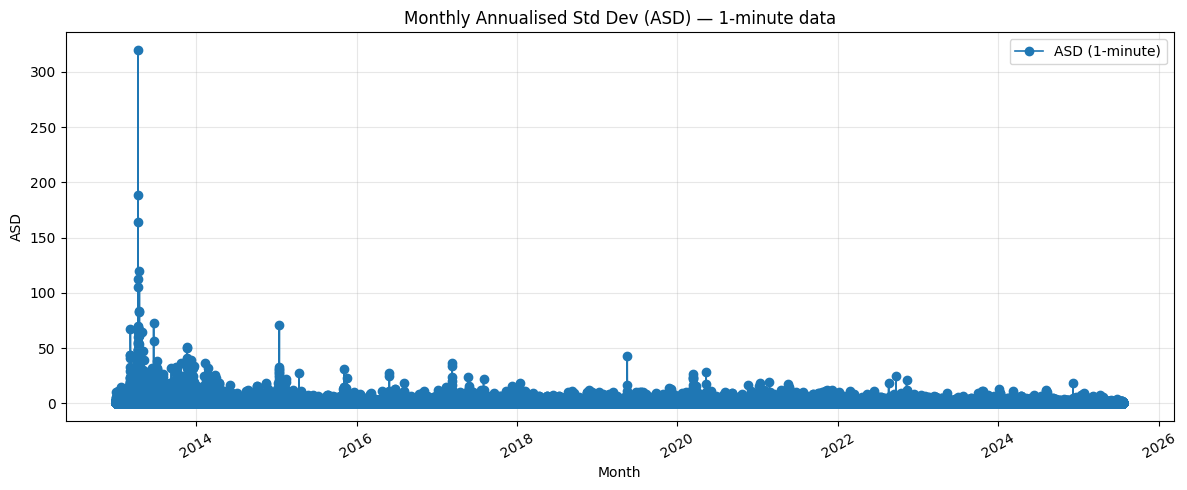

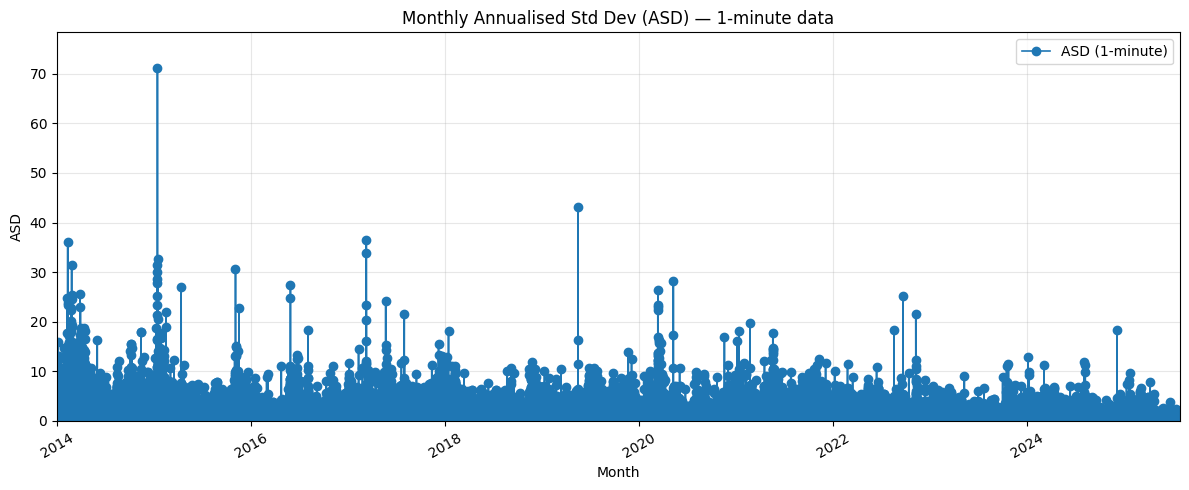

In [42]:
from utils.plotting import plot_monthly_asd_1min

fig, ax, df_asd = plot_monthly_asd_1min(
    asd_monthly,
    show_tail=6,
)

# zoom

fig, ax, df_asd = plot_monthly_asd_1min(
    asd_monthly,
    x_start="2014-01-01",
    x_end="2025-07-31",
    y_pad=0.10,
    show_tail=6,
)



In [31]:
import os
print(os.getcwd())

/Users/jan/Documents/working papers/project 1/preprocessing
